First format Data

In [0]:
files_to_download = [
  'http://ufldl.stanford.edu/housenumbers/train.tar.gz',
  'http://ufldl.stanford.edu/housenumbers/test.tar.gz',
  'http://ufldl.stanford.edu/housenumbers/extra.tar.gz',
]

In [2]:
for file in files_to_download:
  !wget $file

--2020-03-30 20:27:57--  http://ufldl.stanford.edu/housenumbers/train.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404141560 (385M) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 385.42M   103MB/s    in 4.2s    

2020-03-30 20:28:02 (91.4 MB/s) - ‘train.tar.gz’ saved [404141560/404141560]

--2020-03-30 20:28:05--  http://ufldl.stanford.edu/housenumbers/test.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276555967 (264M) [application/x-gzip]
Saving to: ‘test.tar.gz’

test.tar.gz         100%[===================>] 263.74M  91.1MB/s    in 2.9s    

2020-03-30 20:28:08 (91.1 MB/s) - ‘test.tar.gz’ saved [276555967/2

In [0]:
%%capture
!tar xvzf train.tar.gz

In [0]:
%%capture
!tar xvzf test.tar.gz

In [0]:
%%capture
!tar xvzf extra.tar.gz

In [0]:
from tqdm import tqdm

In [0]:
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Input, BatchNormalization
from shutil import copyfile, rmtree
import zipfile
import os

In [0]:
def get_box_data(data, index):
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = data['/digitStruct/bbox'][index]
    data[box[0]].visititems(print_attrs)
    return meta_data

In [0]:
def make_square(im, size=100, fill_color='black'):
    new_im = Image.new('RGB', (size, size), color = fill_color)
    w, h = im.size
    
    original_ratio = w / h
    designer_ratio = 1
    designer_height = size
    designer_width = size

    if original_ratio > designer_ratio:
        designer_height = int(designer_width / original_ratio)
    else:
        designer_width = int(designer_height * original_ratio)

    im = im.resize((designer_width, designer_height))
    new_im.paste(im, (int((size - designer_width) / 2), int((size - designer_height) / 2)))

    return new_im

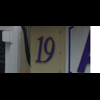

In [71]:
make_square(Image.open(f'train/1.png'))

In [0]:
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

In [0]:
def create_dateset(dataset):
    prepared_dir = f'./{dataset}_prepared'
    data = h5py.File(f'{dataset}/digitStruct.mat', 'r')
    df = []

    rmtree(prepared_dir, ignore_errors=True)
    os.makedirs(prepared_dir, exist_ok=True)

    for i in tqdm(range(len(data['/digitStruct/name']))):
    #for i in range(len(data['/digitStruct/name'])):
        meta_data = get_box_data(data, i)
        meta_data['label'] = np.array(meta_data['label']).astype('int16').tolist()
        num_length = len(meta_data['label'])

        if num_length > 5:
          continue

        file_id = i+1

        max_w = int(max(meta_data['width']))
        max_h = int(max(meta_data['height']))

        w_pad = int(max_w * 1.5)
        h_pad = int(max_h * 1.5)

        box_top = int(min(meta_data['top']))
        box_left = int(min(meta_data['left']))

        box_right = 0
        box_bottom = 0

        for i in range(num_length):
          right = meta_data['left'][i] + meta_data['width'][i]
          bottom = meta_data['top'][i] + meta_data['height'][i]
          if bottom > box_bottom:
            box_bottom = bottom

          if right > box_right:
            box_right = right
        
        img = Image.open(f'{dataset}/{file_id}.png')
        img_w = img.size[0]
        img_h = img.size[1]

        box_left = max(box_left - w_pad, 0)
        box_top = max(box_top - h_pad, 0)

        box_right = min(box_right + w_pad, img_w)
        box_bottom = min(box_bottom + h_pad, img_h)

        img = img.crop(box=(box_left, box_top, box_right, box_bottom))
        img = make_square(img)

        # chagne 10 to 0
        original_label = [d % 10 for d in meta_data['label']]

        label = [10] * (5 - num_length) + original_label
        label = np.array(label, dtype=int)

        label = to_categorical(label, num_classes=11, dtype='int')

        row = {
            'file': f'{file_id}.png', 
            'len': num_length, 
            'orig_label': original_label, 
            'label': label
            }

        
        img.save(f"{prepared_dir}/{file_id}.png") 

        df.append(row)

    df = pd.DataFrame(df)
    df = df.dropna()
    df = df.reset_index(drop=True)
    
    df.to_csv(f'{prepared_dir}/data.csv')

    zipf = zipfile.ZipFile(f'{prepared_dir}.zip', 'w', zipfile.ZIP_DEFLATED)
    zipdir(f'{prepared_dir}/', zipf)
    zipf.close()


In [103]:
create_dateset('test')

100%|██████████| 13068/13068 [02:17<00:00, 94.98it/s]


In [104]:
create_dateset('train')

100%|██████████| 33402/33402 [05:53<00:00, 94.43it/s]


In [105]:
create_dateset('extra')

100%|██████████| 202353/202353 [41:04<00:00, 82.12it/s]


In [109]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [110]:
copyfile('./extra_prepared.zip', '/content/gdrive/My Drive/tf/lab_4/extra_prepared.zip')

'/content/gdrive/My Drive/tf/lab_4/extra_prepared.zip'